In [1]:
import os
import sys

src_dir = './../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import companions

In [4]:
from natsort import natsorted
from scipy.stats import spearmanr
from access_biology_data import relations

In [5]:
from scipy.stats import wilcoxon

In [6]:
outfolder = '220613_human_imbalance_for_longevity_genes'

In [7]:
save_images = True

In [8]:
ref_genes = standardizer.reference_genes(9606, 'orp')

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [9]:
all_de = companions.tstoeger_190427_gtex()

In [10]:
all_de = all_de[
    (all_de['padj'].notnull()) &
    (all_de['gene_ncbi'].isin(ref_genes))
]

In [11]:
f = (all_de['younger'].isin([2, 3])) & (all_de['older'].isin([6, 7]))
all_de = all_de.loc[f, :].copy()

In [12]:
all_de.loc[:, 'reduced_tissue'] = all_de['tissue'].str.replace(
    ' - ', '_').str.replace(' ', '_').str.replace(
    '-', '_').str.replace('(','').str.replace(')', '')

all_de.loc[:, 'condition'] = all_de.loc[:, 'gender'] + 's_' + all_de['reduced_tissue'] + '_' + \
    all_de['older'].astype(int).astype(str) + '_vs_' + all_de['younger'].astype(int).astype(str)

conditions = natsorted(all_de['condition'].unique())

In [13]:
pr = properties.genbank_validated_rna(9606)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])

In [14]:
from access_aging_data import earlier_studies

In [15]:
hagr = earlier_studies.hagr_mapped_summary(9606)

hagr = hagr[hagr['influence'].isin(['anti_longevity', 'pro_longevity'])]

In [16]:
len(set([x for x in hagr['gene_ncbi'] if x in ref_genes]))

665

In [17]:
len(ref_genes)

19229

In [18]:
len(set([x for x in hagr['gene_ncbi'] if x in ref_genes])) / len(ref_genes)

0.03458318165271205

In [19]:
# hg = relations.homologene()

# ho = pd.merge(
#     hg[hg['taxon_ncbi']==9606][['homologene_group', 'gene_ncbi']],
#     hg[hg['taxon_ncbi']==559292][['homologene_group', 'gene_ncbi']],
#     on='homologene_group',
#     suffixes=('_h', '_y')
# ).drop_duplicates()

In [20]:
# path_to_data = inout.get_internal_path(
#     (
#         'datasets/general/resources/publications/'
#         'hu_2014/Supplemental_Table_1.xls'
#     )
# )

# df_hu = pd.read_excel(
#     path_to_data,
#     sheet_name='young vs old'
# )

# taxon_id = 559292
# g = meta.gene_info(taxon_id)

In [21]:
# m = pd.merge(
#     g[['gene_ncbi', 'LocusTag']].rename(columns={'LocusTag': 'gene'}), 
#     df_hu)

In [22]:
# highly_responsive  = ho[ho['gene_ncbi_y'].isin(
#     m[
#         (m['logFC']>0) &
#         (m['FDR']<0.05)
#     ]['gene_ncbi']
# )]['gene_ncbi_h'].unique()

In [23]:
# #Genes to consider
# ho_in_m = ho[ho['gene_ncbi_y'].isin(m['gene_ncbi'])]
# all_de = all_de[all_de['gene_ncbi'].isin(ref_genes)]
# # all_de = all_de[all_de['gene_ncbi'].isin(ho['gene_ncbi_h'])]

In [24]:
out = pd.DataFrame(index=conditions, columns=[
     'corr_longevity', 'corr_non_longevity', 'corr_high', 'corr_non_high'
]).rename_axis('condition')

In [25]:
for condition in conditions:
    d = all_de[
        all_de['condition']==condition
    ]

    d = d[['gene_ncbi', 'o_over_y']].dropna()
    d = pd.merge(d, pr)
    
    
    f  = d['gene_ncbi'].isin(hagr['gene_ncbi'])
    r, p = spearmanr(d.loc[f, 'log_length'], d.loc[f, 'o_over_y'])
    out.loc[condition, 'corr_longevity'] = r
    
    r, p = spearmanr(d.loc[~f, 'log_length'], d.loc[~f, 'o_over_y'])
    out.loc[condition, 'corr_non_longevity'] = r
    
    

In [26]:
out = out.reset_index()

In [27]:
mega = pd.merge(out, all_de[['condition', 'gender', 'tissue', 'younger', 'older']].drop_duplicates())

In [28]:
mega['corr_longevity'] = mega['corr_longevity'].astype(float)
mega['corr_non_longevity'] = mega['corr_non_longevity'].astype(float)

In [29]:
m = mega.groupby(
    ['gender', 'tissue']
)[['corr_longevity', 'corr_non_longevity']].median().reset_index()

In [30]:
x = 'corr_non_longevity'
y = 'corr_longevity'

In [31]:
spearmanr(m[x], m[y])

SpearmanrResult(correlation=0.9294117647058823, pvalue=4.018939102942523e-38)

Text(0, 0.5, 'corr_longevity')

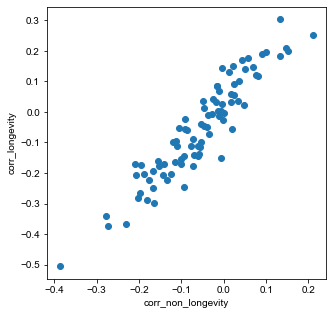

In [32]:
plt.figure(figsize=(5, 5))
plt.scatter(m[x], m[y])
# plt.xlim([-0.6, 0.4])
# plt.ylim([-0.6, 0.4])
plt.xlabel(x)
plt.ylabel(y)

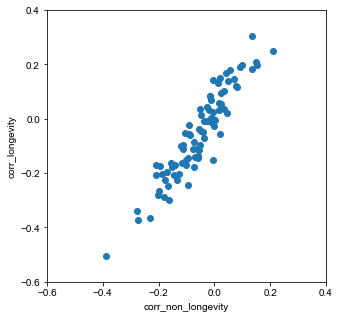

In [33]:
plt.figure(figsize=(5, 5))
plt.scatter(m[x], m[y])
plt.xlim([-0.6, 0.4])
plt.ylim([-0.6, 0.4])
plt.xlabel(x)
plt.ylabel(y)

if save_images:
    export.export_image(
        '{}/comparison_longevity.pdf'.format(outfolder))